# Criação, treino e teste do Modelo

## Instalando bibliotecas 

In [1]:
!pip install tensorflow scikit-learn imblearn


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Leitura e Verificação dos Dados

In [37]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [38]:
comum = pd.read_parquet('DF_KNRS_COMUM_PROCESSADO.parquet')
tempo = pd.read_parquet('tempo_de_cada_knr_por_halle.parquet')

df = comum.merge(tempo, on='KNR', how='right')
df = df.dropna()
print(df['TEM_FALHA_ROD'].value_counts())  # Verificando a distribuição da variável alvo
print(df.isnull().sum())
print('\n----------\n')

df = df.dropna()  # Removendo valores nulos
df = df.drop(columns=["QTD_HALLE_ROD", "QTD_HALLE_AGUA", "QTD_HALLE_ZP8", "QTD_HALLE_ZP8R"])

print('\n----------\n')
print(df['TEM_FALHA_ROD'].value_counts())  # Verificando a distribuição da variável alvo
print(df.isnull().sum())

TEM_FALHA_ROD
0.0    12967
1.0      616
Name: count, dtype: int64
KNR                       0
QTD_STATUS_1_OK           0
QTD_STATUS_1_NOK          0
QTD_STATUS_2_OK           0
QTD_STATUS_2_NOK          0
QTD_STATUS_718_OK         0
QTD_STATUS_718_NOK        0
TEMPO_MEDIO               0
MOTOR                     0
COR                       0
QTD_HALLE_                0
QTD_HALLE_AGUA            0
QTD_HALLE_BUY             0
QTD_HALLE_CAB             0
QTD_HALLE_DKA             0
QTD_HALLE_ESPC            0
QTD_HALLE_PROC            0
QTD_HALLE_PROF            0
QTD_HALLE_PVC             0
QTD_HALLE_ROD             0
QTD_HALLE_RUID            0
QTD_HALLE_TLUI            0
QTD_HALLE_ZP5             0
QTD_HALLE_ZP5A            0
QTD_HALLE_ZP6             0
QTD_HALLE_ZP61            0
QTD_HALLE_ZP62            0
QTD_HALLE_ZP7             0
QTD_HALLE_ZP8             0
QTD_HALLE_ZP82            0
QTD_HALLE_ZP8R            0
QTD_SGROUP_#MULTIVALUE    0
QTD_SGROUP_-2             0
QTD_SGROUP

In [39]:
qtd_ocorrencias = df[df['QTD_HALLE_ESPC'] > 1].shape[0]
print(f"Ocorrências de valor 1 na coluna QTD_HALLE_ESPC: {qtd_ocorrencias}")


Ocorrências de valor 1 na coluna QTD_HALLE_ESPC: 248


In [40]:
df.head()

,KNR,QTD_STATUS_1_OK,QTD_STATUS_1_NOK,QTD_STATUS_2_OK,QTD_STATUS_2_NOK,QTD_STATUS_718_OK,QTD_STATUS_718_NOK,TEMPO_MEDIO,MOTOR,COR,...,QTD_SGROUP_2,QTD_SGROUP_4,QTD_SGROUP_5,QTD_SGROUP_9830946,TEM_FALHA_ROD,ZP5_MIN,ZP5A_MIN,ZP61_MIN,ZP6 / ZP62_MIN,CAB_MIN
6890,2023-3016123,7.0,0.0,840.0,0.0,50.0,1.0,50.883333,CWL,2R2R,...,3.0,1.0,0.0,0.0,1.0,1740.483333,5605.383333,102.200000,25.883333,57.666667
6891,2023-3016123,7.0,0.0,803.0,0.0,48.0,1.0,92.250000,CWL,2R2R,...,3.0,1.0,0.0,0.0,1.0,1740.483333,5605.383333,102.200000,25.883333,57.666667
7010,2023-3016194,7.0,0.0,846.0,9.0,58.0,2.0,52.683333,DHS,0Q0Q,...,7.0,2.0,0.0,0.0,0.0,2582.033333,5817.316667,53.133333,23.350000,11454.383333
7011,2023-3016194,7.0,0.0,802.0,9.0,56.0,2.0,73.350000,DHS,0Q0Q,...,7.0,2.0,0.0,0.0,0.0,2582.033333,5817.316667,53.133333,23.350000,11454.383333
7252,2023-3026027,7.0,0.0,850.0,6.0,53.0,4.0,48.633333,DHS,2R2R,...,7.0,3.0,0.0,0.0,0.0,1772.450000,5611.933333,36.833333,25.966667,4538.233333


## Pré-processamento dos dados

In [41]:
from sklearn.preprocessing import MinMaxScaler
# Criando variáveis dummies
df = pd.get_dummies(df, columns=['COR', 'MOTOR'], drop_first=True)

# Removendo colunas desnecessárias
df = df.drop(columns=["KNR"])


# Exemplo de DataFrame com colunas numéricas e de string
# Suponha que df seja o seu DataFrame original

# Separar as colunas numéricas
df_numerical = df.select_dtypes(include=['float64', 'int64'])

# Separar as colunas não numéricas
df_non_numerical = df.select_dtypes(exclude=['float64', 'int64'])

# Aplicar o MinMaxScaler nas colunas numéricas
scaler = MinMaxScaler()
df_numerical_scaled = pd.DataFrame(scaler.fit_transform(df_numerical), columns=df_numerical.columns)



In [42]:
df_numerical_scaled.head()

,QTD_STATUS_1_OK,QTD_STATUS_1_NOK,QTD_STATUS_2_OK,QTD_STATUS_2_NOK,QTD_STATUS_718_OK,QTD_STATUS_718_NOK,TEMPO_MEDIO,QTD_HALLE_,QTD_HALLE_BUY,QTD_HALLE_CAB,...,QTD_SGROUP_2,QTD_SGROUP_4,QTD_SGROUP_5,QTD_SGROUP_9830946,TEM_FALHA_ROD,ZP5_MIN,ZP5A_MIN,ZP61_MIN,ZP6 / ZP62_MIN,CAB_MIN
0,0.466667,0.0,0.752688,0.000000,0.263158,0.014085,0.002383,0.0,0.0,0.0,...,0.157895,0.055556,0.0,0.0,1.0,0.022740,0.103751,0.005534,0.000860,0.002519
1,0.466667,0.0,0.719534,0.000000,0.252632,0.014085,0.004320,0.0,0.0,0.0,...,0.157895,0.055556,0.0,0.0,1.0,0.022740,0.103751,0.005534,0.000860,0.002519
2,0.466667,0.0,0.758065,0.089109,0.305263,0.028169,0.002467,0.0,0.0,0.0,...,0.368421,0.111111,0.0,0.0,0.0,0.041130,0.107964,0.002762,0.000749,0.520787
3,0.466667,0.0,0.718638,0.089109,0.294737,0.028169,0.003435,0.0,0.0,0.0,...,0.368421,0.111111,0.0,0.0,0.0,0.041130,0.107964,0.002762,0.000749,0.520787
4,0.466667,0.0,0.761649,0.059406,0.278947,0.056338,0.002277,0.0,0.0,0.0,...,0.368421,0.166667,0.0,0.0,0.0,0.023439,0.103882,0.001841,0.000864,0.206273


## Balanceamento das Classes

In [43]:
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
X = df_numerical_scaled.drop(columns=['TEM_FALHA_ROD'])  # Removendo a variável alvo, mantendo apenas as variáveis preditoras
y = df_numerical_scaled['TEM_FALHA_ROD']  # Definindo a variável alvo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)# Apply SMOTE to the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

## Dividindo o dataset entre treino e teste

In [44]:
#from sklearn.model_selection import train_test_split  # Importa a função para dividir os dados em conjuntos de treino e teste

#X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)  
# Divide os dados balanceados em conjuntos de treino (80%) e teste (20%), com uma semente de aleatoriedade fixa para reprodução

## Redimensionamento dos dados

In [45]:
#X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))  
# Altera a forma de X_train para (n amostras, 1, n características) para compatibilidade com redes neurais que esperam uma dimensão adicional

#X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))  
# Altera a forma de X_test de maneira semelhante

#X_train = np.array(X_train, dtype=np.float32)  
# Converte X_train para um array NumPy com tipo de dado float32

#y_train = np.array(y_train, dtype=np.float32)  
# Converte y_train para um array NumPy com tipo de dado float32

## Construção dos Modelos (LSTM e GRU)

### Modelo GRU

In [51]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Function to reshape the datasets for compatibility with the GRU model
def reshape_dataset(X_dataset, y_dataset):
    X_dataset = X_dataset.values.reshape((X_dataset.shape[0], 1, X_dataset.shape[1]))  
    X_dataset = np.array(X_dataset, dtype=np.float32)  
    y_dataset = np.array(y_dataset, dtype=np.float32)
    return X_dataset, y_dataset

# Function to create the GRU model
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, input_shape=input_shape))  # GRU layer
    model.add(Dropout(0.2))  # Dropout to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])  # Compile the model
    return model

In [52]:
# Initialize KFold with 5 splits
kfold = KFold(n_splits=5)

# Lists to store the training and validation losses for each fold
train_losses = []
val_losses = []
cross_validation_scores = [] 

# Perform cross-validation
for train_indices, test_indices in kfold.split(X_resampled):
    # Split the data into training and testing sets for this fold
    X_train_fold, y_train_fold = X_resampled.iloc[train_indices], y_resampled.iloc[train_indices]
    X_test_fold, y_test_fold = X_resampled.iloc[test_indices], y_resampled.iloc[test_indices]

    # Reshape both the training and test datasets
    X_train_reshaped, y_train_reshaped = reshape_dataset(X_train_fold, y_train_fold)
    X_test_reshaped, y_test_reshaped = reshape_dataset(X_test_fold, y_test_fold)

    # Create a new GRU model for this fold
    model_gru = create_gru_model(input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))

    # Train the model and store the training history (with validation split for tracking validation loss)
    history = model_gru.fit(X_train_reshaped, y_train_reshaped, 
                            epochs=10, 
                            batch_size=32, 
                            validation_split=0.2,  # Use 20% of the training data as validation data
                            verbose=1)
    
    # Evaluate the model on the current fold's test data
    score = model_gru.evaluate(X_test_reshaped, y_test_reshaped, verbose=1)
    
    # Append the score to the cross-validation results list
    cross_validation_scores.append(score)

    # Store training and validation losses
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

# Output the cross-validation scores
print("Cross-validation scores:", cross_validation_scores)
print("Average score:", np.mean(cross_validation_scores, axis=0))

Epoch 1/10


C:\Users\Inteli\Documents\GitHub\2024-2A-T08-EC07-G05\src\notebooks\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


364/364 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5402 - loss: 0.6881 - val_accuracy: 0.7493 - val_loss: 0.6482
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6424 - loss: 0.6586 - val_accuracy: 0.8253 - val_loss: 0.5591
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6846 - loss: 0.6242 - val_accuracy: 0.7950 - val_loss: 0.5407
Epoch 4/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7191 - loss: 0.5901 - val_accuracy: 0.8594 - val_loss: 0.4839
Epoch 5/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7560 - loss: 0.5546 - val_accuracy: 0.9082 - val_loss: 0.4196
Epoch 6/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8170 - loss: 0.5053 - val_accuracy: 0.7851 - val_loss: 0.5320
Epoch 7/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8777 - loss: 0.4467 - val_accuracy: 0.9309 - val_loss: 0.3965
Epoch 8/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9099 - loss: 0.3874 - val_accuracy: 0.9835 - val_

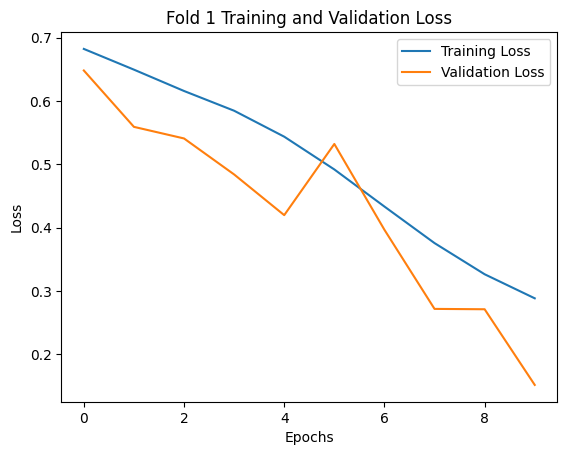

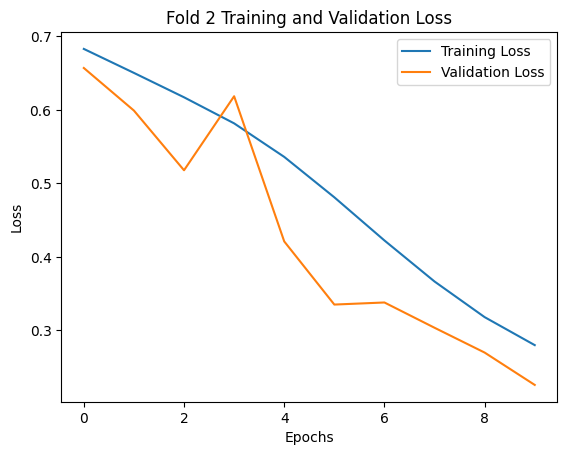

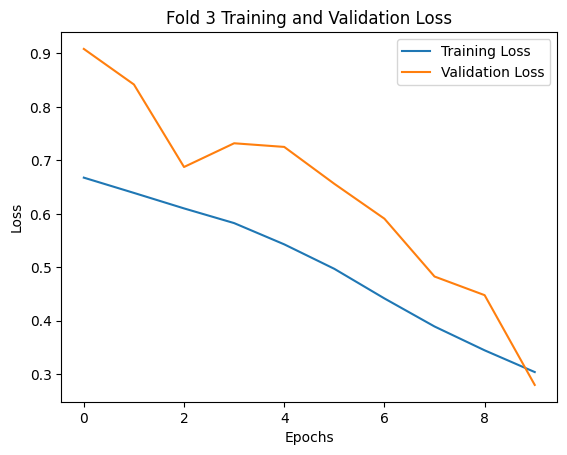

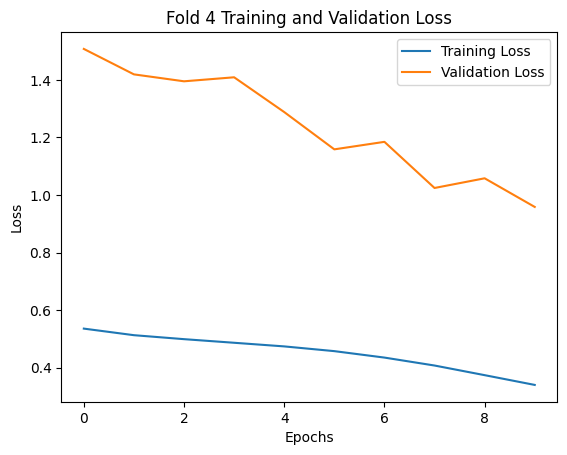

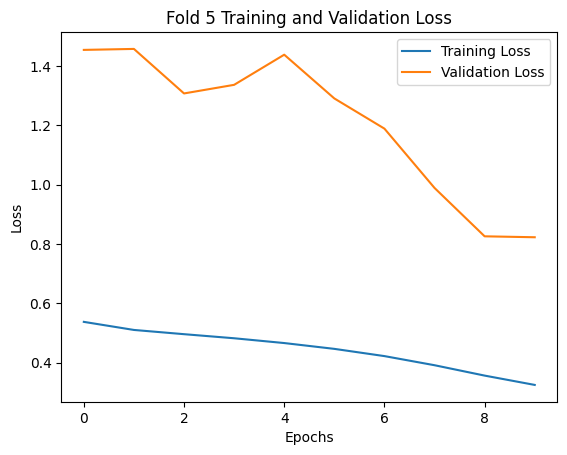

In [53]:
# Plot the training and validation loss for each fold
for i in range(len(train_losses)):
    plt.figure()
    plt.plot(train_losses[i], label='Training Loss')
    plt.plot(val_losses[i], label='Validation Loss')
    plt.title(f'Fold {i+1} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Modelo LSTM

In [54]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Function to reshape the datasets for compatibility with the LSTM model
def reshape_dataset(X_dataset, y_dataset):
    X_dataset = X_dataset.values.reshape((X_dataset.shape[0], 1, X_dataset.shape[1]))  
    X_dataset = np.array(X_dataset, dtype=np.float32)  
    y_dataset = np.array(y_dataset, dtype=np.float32)
    return X_dataset, y_dataset

# Function to create the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))  # LSTM layer
    model.add(Dropout(0.2))  # Dropout to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])  # Compile the model
    return model


In [55]:
# Initialize KFold with 5 splits
kfold = KFold(n_splits=5)

# Lists to store the training and validation losses for each fold
train_losses = []
val_losses = []
cross_validation_scores_lstm = [] 

# Perform cross-validation
for train_indices, test_indices in kfold.split(X_resampled):
    # Split the data into training and testing sets for this fold
    X_train_fold, y_train_fold = X_resampled.iloc[train_indices], y_resampled.iloc[train_indices]
    X_test_fold, y_test_fold = X_resampled.iloc[test_indices], y_resampled.iloc[test_indices]

    # Reshape both the training and test datasets
    X_train_reshaped, y_train_reshaped = reshape_dataset(X_train_fold, y_train_fold)
    X_test_reshaped, y_test_reshaped = reshape_dataset(X_test_fold, y_test_fold)

    # Create a new LSTM model for this fold
    model_lstm = create_lstm_model(input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))

    # Train the model and store the training history (with validation split for tracking validation loss)
    history = model_lstm.fit(X_train_reshaped, y_train_reshaped, 
                             epochs=10, 
                             batch_size=32, 
                             validation_split=0.2,  # Use 20% of the training data as validation data
                             verbose=1)
    
    # Evaluate the model on the current fold's test data
    score = model_lstm.evaluate(X_test_reshaped, y_test_reshaped, verbose=1)
    
    # Append the score to the cross-validation results list
    cross_validation_scores_lstm.append(score)

    # Store training and validation losses
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

# Output the cross-validation scores
print("Cross-validation scores for LSTM:", cross_validation_scores_lstm)
print("Average score for LSTM:", np.mean(cross_validation_scores_lstm, axis=0))

Epoch 1/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5326 - loss: 0.6904 - val_accuracy: 0.8453 - val_loss: 0.6412
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6379 - loss: 0.6643 - val_accuracy: 0.7111 - val_loss: 0.6215
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6738 - loss: 0.6272 - val_accuracy: 0.7077 - val_loss: 0.6103
Epoch 4/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7056 - loss: 0.5957 - val_accuracy: 0.8088 - val_loss: 0.5170
Epoch 5/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7457 - loss: 0.5605 - val_accuracy: 0.8597 - val_loss: 0.4754
Epoch 6/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8090 - loss: 0.5071 - val_accuracy: 0.8380 - val_loss: 0.4878
Epoch 7/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8669 - loss: 0.4462 - val_accuracy: 0.9484 - val_loss: 0.3458
Epoch 8/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9149 - loss: 0.3861 - val_accuracy: 0.

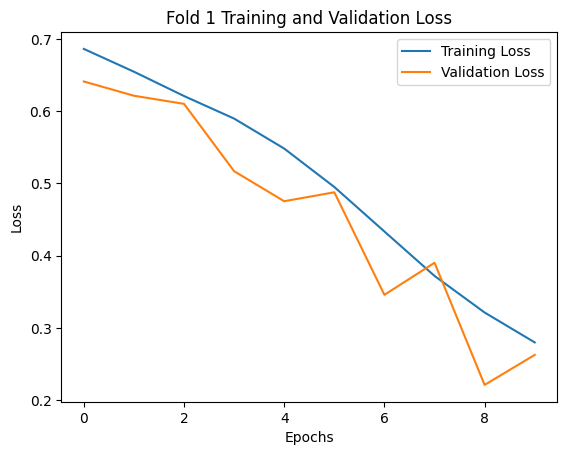

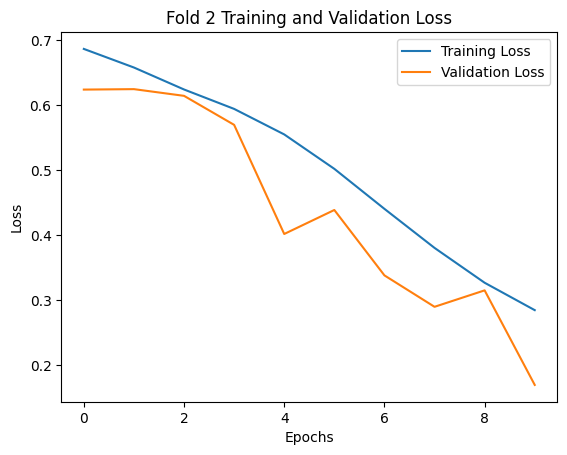

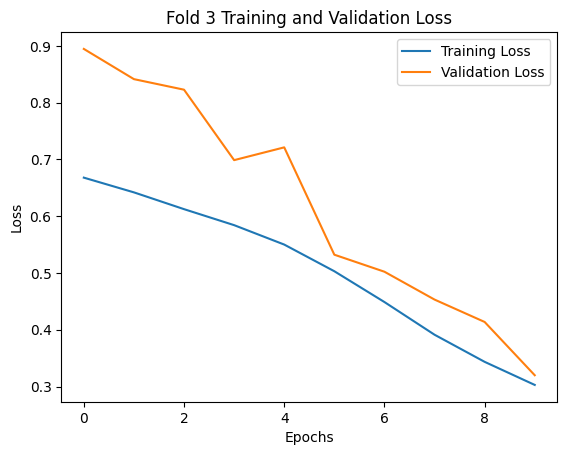

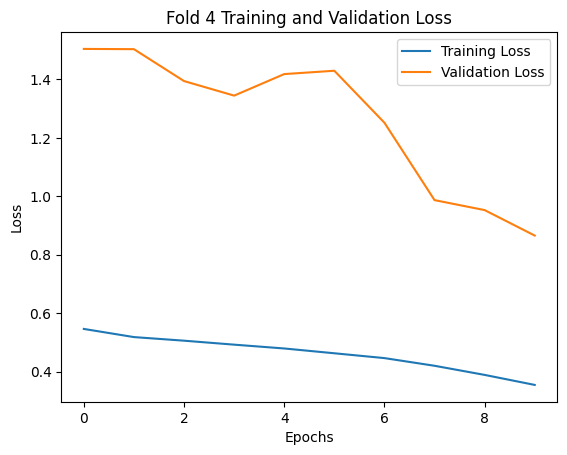

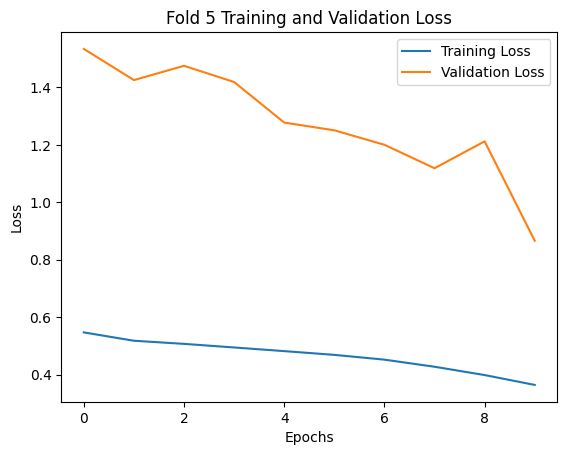

In [56]:
# Plot the training and validation loss for each fold
for i in range(len(train_losses)):
    plt.figure()
    plt.plot(train_losses[i], label='Training Loss')
    plt.plot(val_losses[i], label='Validation Loss')
    plt.title(f'Fold {i+1} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Avaliando o Modelo

### GRU

### LSTM

In [16]:
# Avaliar o modelo LSTM com os dados de teste
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test, y_test)
print(f'Test Loss LSTM: {loss_lstm}')
print(f'Test Accuracy LSTM: {accuracy_lstm}')

# Fazer previsões com o modelo LSTM
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)

# Exibir o relatório de classificação
print(classification_report(y_test, y_pred_lstm))

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9732 - loss: 0.1462
Test Loss LSTM: 0.13239046931266785
Test Accuracy LSTM: 0.9738723635673523
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97      1823
         1.0       0.95      1.00      0.97      1813

    accuracy                           0.97      3636
   macro avg       0.98      0.97      0.97      3636
weighted avg       0.98      0.97      0.97      3636

